# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import gmmPLSR_tuning
from msresist.plsr import plotMeasuredVsPredicted, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnGMM
from msresist.sequence_analysis import FormatName
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
pd.set_option('display.max_colwidth', 1000)

ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)

header = ABC_mc.columns
treatments = ABC_mc.columns[2:12]

data = ABC_mc.iloc[:,2:12].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:11]

In [3]:
ABC_mc

,peptide-phosphosite,Master Protein Descriptions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428,position
1,---MRyVASYL,60S acidic ribosomal protein P2,-0.041348,0.330638,0.079619,-0.287413,-0.230024,-0.550611,-0.398655,-0.141238,-0.088036,1.327068,Y3-p
2,---MtyAYLFK,Ras-related protein Rab-2B,0.633928,0.259916,-0.055945,-0.434915,0.208498,0.418103,0.471005,-0.675985,-0.459938,-0.364667,Y3-p
3,-MAKAyDHLFK,Ras-related protein Rab-13,0.541208,0.090077,-0.229873,-1.142080,0.287358,-0.069477,1.225244,-0.160944,-0.093620,-0.447893,Y5-p
5,-MARDyDHLFK,Ras-related protein Rab-35,0.356559,-0.176429,0.267839,-0.796749,0.275687,-0.194960,0.501464,-0.143006,0.196517,-0.286921,Y5-p
7,AAAIAyGLDRT,Heat shock 70 kDa protein 1A,0.431886,0.894781,0.373969,-0.304444,-1.203818,-0.086804,-0.276191,-0.184870,-0.155607,0.511098,Y183-p
8,AAASNyV----,Claudin-4,1.621805,1.041805,0.585895,-0.580377,-0.227355,-0.556887,-0.448397,-0.878971,0.172464,-0.729983,Y208-p
9,AAEPEyPKGIR,"Adenylate kinase 2, mitochondrial",-0.017244,0.100164,-0.087186,-1.367959,0.123011,-0.018631,-0.568576,0.760426,0.780999,0.294996,Y12-p
10,AAGYPtYRLGY,Kin of IRRE-like protein 1,1.253109,-0.216971,0.112321,-0.218133,-1.194428,-0.304462,-0.091888,-0.084560,0.294822,0.450191,T703-p
11,AANPAyGRYNP,DNA replication licensing factor MCM7,0.737244,0.324275,0.413028,0.211337,-0.486523,-0.393193,-0.142017,-0.033196,-0.131481,-0.499472,Y492-p
15,AAYDIsEDEED,Choline-phosphate cytidylyltransferase A,-0.262960,-0.046467,-0.246482,0.057388,-0.142335,-0.301030,-0.411807,-0.318526,1.931780,-0.259560,S362-p


### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:11]

# Re-implementation using Gaussian Mixture Model clustering

In [7]:
maxComp = 4

In [8]:
kmeans = MyOwnGMM(maxComp).fit(data, Y_cv)
centers = kmeans.transform(data)

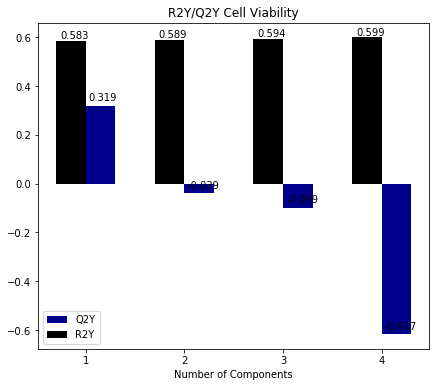

In [9]:
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

In [10]:
# CVresults_max, CVresults_min, best_params = gmmPLSR_tuning(data, Y_cv)
# CVresults_min.nlargest(30, "mean_test_scores")

,#ComponentsGMM,#ComponentsPLSR,mean_test_scores,mean_train_scores
5,4,1,-155.914232,-1.250957e+02
65,12,1,-170.559347,-1.170584e+02
14,6,1,-175.397035,-1.190533e+02
20,7,1,-176.085849,-1.182532e+02
44,10,1,-179.007836,-1.170471e+02
54,11,1,-181.182507,-1.169637e+02
77,13,1,-185.697133,-1.105256e+02
90,14,1,-186.608158,-1.125293e+02
0,2,1,-187.159436,-1.303107e+02
35,9,1,-187.680325,-1.178086e+02


In [11]:
ncl, ncomp = 4, 2

In [12]:
gmm_plsr = Pipeline([('gmm', MyOwnGMM(ncl)), ('plsr', PLSRegression(ncomp))])

In [13]:
X_scores, Y_scores = gmm_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = gmm_plsr.named_steps.plsr.x_loadings_[:, 0], gmm_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = gmm_plsr.named_steps.plsr.y_loadings_[:, 0], gmm_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.6197806178458065 
 p-value:  0.05596714110483589


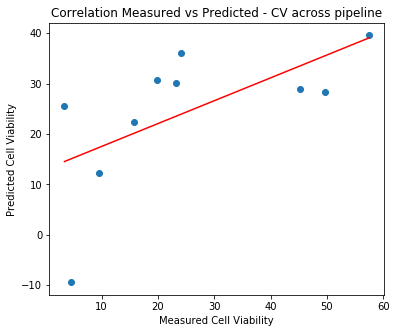

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, gmm_plsr, centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

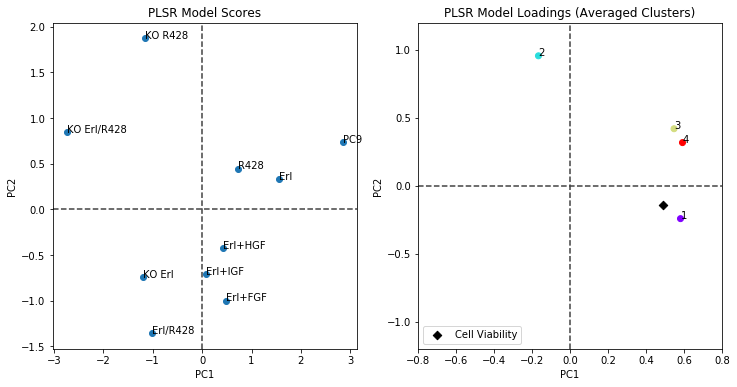

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
# axs[0].set_xlim([-3.5, 3.5])
# axs[0].set_ylim([-1, 1])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=3)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.8, 0.8])
axs[1].set_ylim([-1.2, 1.2]);

In [16]:
clustermembers = gmm_plsr.named_steps.gmm.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,Ras-related protein Rab-13,-MAKAyDHLFK,60S acidic ribosomal protein P2,---MRyVASYL,Coactosin-like protein,ACRAAyNLVRD,Ras-related protein Rab-2B,---MtyAYLFK
1,Heat shock 70 kDa protein 1A,AAAIAyGLDRT,Choline-phosphate cytidylyltransferase A,AAYDIsEDEED,Tubulin-folding cofactor B,ARLGEyEDVSR,Ras-related protein Rab-35,-MARDyDHLFK
2,Kin of IRRE-like protein 1,AAGYPtYRLGY,Pyruvate kinase PKM,AEAAIyHLQLF,SHC-transforming protein 1,FDDPSyVNVQN,Claudin-4,AAASNyV----
3,Lethal(2) giant larvae protein homolog 1,CFDPYsDDPRL,Nucleophosmin,AKFINyVKNCF,Catenin delta-1,FHPEPyGLEDD,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR
4,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Ras and Rab interactor 1,AQDPLyDVPNA,GRB2-associated-binding protein 2,FRDSTyDLPRS,DNA replication licensing factor MCM7,AANPAyGRYNP
5,Desmoplakin,EKsAIyQLEEE,Receptor tyrosine-protein kinase erbB-3,ASEQGyEEMRA,Mitogen-activated protein kinase 1,GFLTEyVATRW,Mitogen-activated protein kinase 13,ADAEMtGYVVT
6,Tyrosine-protein kinase receptor UFO,ENSEIyDYLRQ,Aldo-keto reductase family 1 member C3,ASHPNyPYSDE,Mitogen-activated protein kinase 3,GFLTEyVATRW,Envoplakin,AEDAVyELQSK
7,Y+L amino acid transporter 2,EPGRPtPTYHL,Cysteine and glycine-rich protein 1,CQKtVyFAEEV,POTE ankyrin domain family member F,ISKQEyDESGP,Kinesin light chain 2,AEEVEyYYRRA
8,Annexin A5,GDTSGyYQRML,FACT complex subunit SSRP1,DEYADsDEDQH,Histone H3.1,KKPHRyRPGTV,Receptor tyrosine-protein kinase erbB-2,AENPEyLGLDV
9,Activated CDC42 kinase 1,GVKKPtYDPVS,Tight junction protein ZO-1,DPEPVsDNEED,14-3-3 protein theta,LLSVAyKNVVG,Protein-glutamine gamma-glutamyltransferase 2,AERDLyLENPE


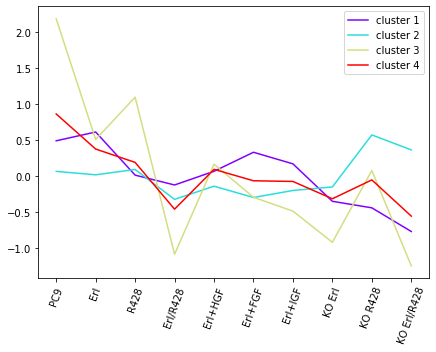

In [17]:
fig = plt.figure(figsize=(7,5))

centers = gmm_plsr.named_steps.gmm.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);

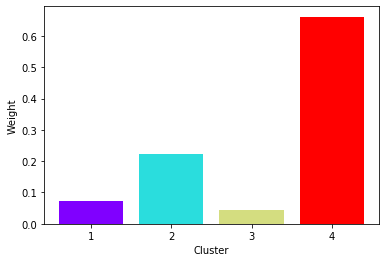

In [18]:
weights = gmm_plsr.named_steps.gmm.weights()

plt.bar(np.linspace(1, weights.size, weights.size), weights, color=colors_);
plt.xticks(np.linspace(1, weights.size, weights.size))
plt.xlabel('Cluster');
plt.ylabel('Weight');